In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import seaborn
from pylab import rcParams
from scipy import stats
import gc
%matplotlib inline

In [2]:
import multiprocessing
multiprocessing.cpu_count()

4

Считаем данные и отфильтруем только за первые 4 месяца 2016 года. Так же отделим часы от даты поездки в отдельную колонку

In [3]:
%%time
data = pd.read_csv('../result_data.csv', index_col=0, parse_dates=['pickup_datetime'])
all_data = data.copy()
data = data[(data['pickup_datetime'] < '2016-05-01') & (data['pickup_datetime'] >= '2016-01-01')]
data['time'] = data['pickup_datetime'].dt.time

Wall time: 3.83 s


In [4]:
regions = np.unique(data['region_id']).astype(int)

In [5]:
print data.head()
print data.info()

        pickup_datetime  region_id  count      time
2680560      2016-01-01     1075.0     80  00:00:00
2680561      2016-01-01     1076.0    144  00:00:00
2680562      2016-01-01     1077.0     50  00:00:00
2680563      2016-01-01     1125.0     77  00:00:00
2680564      2016-01-01     1126.0    319  00:00:00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 296208 entries, 2680560 to 2976767
Data columns (total 4 columns):
pickup_datetime    296208 non-null datetime64[ns]
region_id          296208 non-null float64
count              296208 non-null int64
time               296208 non-null object
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 11.3+ MB
None


Теперь сгруппируем поездки по регионам и часам отправления

In [6]:
%%time
table = pd.DataFrame(index=pd.date_range("00:00:00", "23:00:00", freq='1H').time)
t = data.groupby(['region_id', 'time'])['count'].sum()
for region in regions:
    table[region] = t[region]

Wall time: 96 ms


Стандартизируем значения полученной таблицы

In [7]:
for column in table.columns:
    mean = table[column].mean()
    std = table[column].std()
    table[column] = (table[column] - mean) / np.sqrt(std)

In [8]:
table2 = table.transpose()
print table2.head()

       00:00:00    01:00:00    02:00:00    03:00:00    04:00:00    05:00:00  \
1075 -43.724951  -72.597249  -90.947340  -99.859331 -102.489882  -97.850546   
1076 -96.470452 -124.686611 -140.493625 -150.942871 -152.466053 -138.384603   
1077 -86.602152 -110.948186 -121.365480 -125.124029 -125.019986 -112.742926   
1125 -27.733347  -68.532443  -91.006385 -105.535156 -104.061455 -103.869233   
1126 -43.300536 -106.406070 -147.911589 -169.391991 -170.219310 -166.989774   

        06:00:00   07:00:00    08:00:00   09:00:00    ...        14:00:00  \
1075  -76.423506 -46.004763    6.893241  -1.381040    ...       73.262858   
1076  -95.341379 -15.102675   64.156079  59.586531    ...      112.780755   
1077  -46.467610  49.694023  118.453363  55.247312    ...       46.338640   
1125  -59.994587 -20.028453   26.136837   0.715493    ...       30.349700   
1126 -110.642344 -58.890025    0.906230  14.203147    ...       69.274711   

       15:00:00   16:00:00   17:00:00    18:00:00    19:00:00 

Оптимальным (субъективно) количеством кластеров оказалось 4. Данное количество хорошо отражает уникальные особенности каждого из кластеров, а элементы разных кластеров не выглядят похожими. Отрисуем по 3 элемента каждого кластера.

In [9]:
n_clusters = 4
cluster_model = KMeans(n_clusters=n_clusters, random_state=1)
res = cluster_model.fit_predict(table2)
table2['cluster'] = res

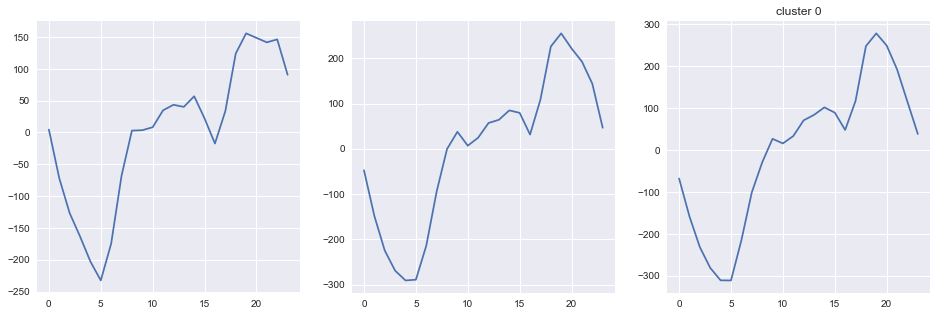

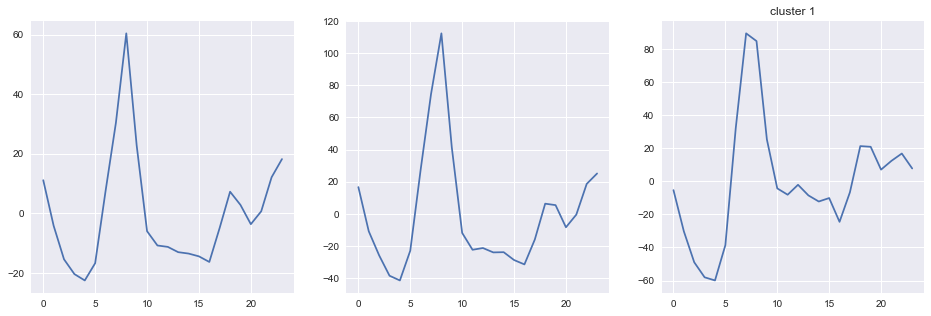

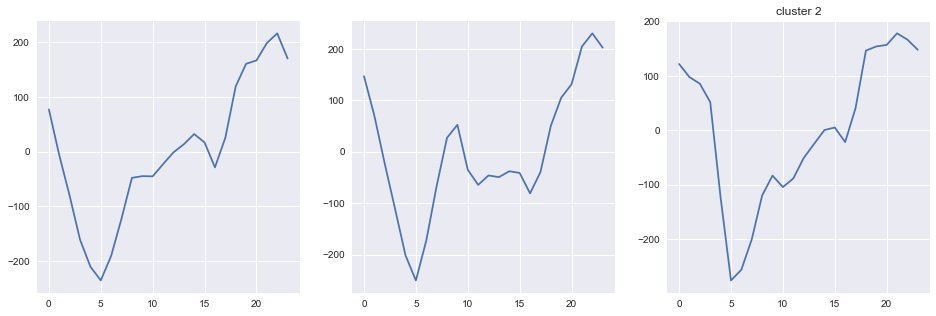

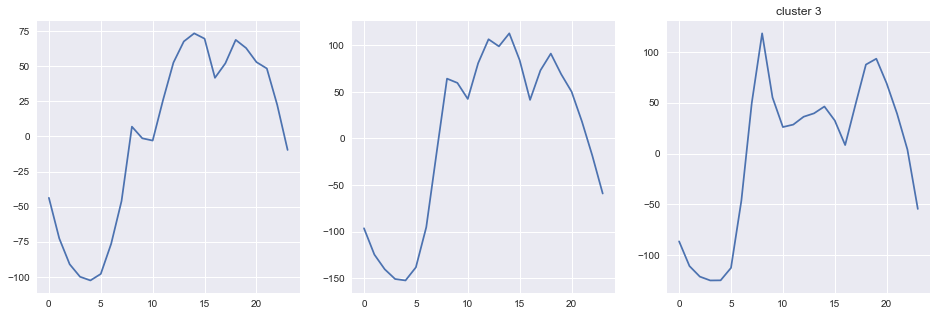

In [10]:
clusters = {}
for i in range(n_clusters):
    n = min(3, table2[table2['cluster'] == i].shape[0])
    plt.figure(figsize=(16, 5))
    
    for j in range(n):
        region = table2[table2['cluster'] == i].index[j]
        region_data = table2.loc[region][:-1]
        plt.subplot(131 + j)
        plt.plot(region_data.values)
    clusters[i] = table2[table2['cluster'] == i].index[1]
    plt.title('cluster ' + str(i))
    plt.show()

Теперь разобьем все регионы по кластерам. Словарь cluster_element отображает номер кластера в список значений первого элемента этого кластера. Выбран первый, т.к. сложно выделить наиболее типичный. Естественно, это может сказаться на точности. Но как видно далее, это не так уже и критично - результат метрики относительно других работ средний.

In [11]:
cluster_element = {}
for cluster_id in range(n_clusters):
    cluster_element[cluster_id] = data[data['region_id'] == clusters[cluster_id]][['pickup_datetime', 'count']]

In [12]:
cluster_element

{0:             pickup_datetime  count
 2680578 2016-01-01 00:00:00    759
 2680680 2016-01-01 01:00:00    518
 2680782 2016-01-01 02:00:00    401
 2680884 2016-01-01 03:00:00    391
 2680986 2016-01-01 04:00:00    388
 2681088 2016-01-01 05:00:00    244
 2681190 2016-01-01 06:00:00    144
 2681292 2016-01-01 07:00:00    115
 2681394 2016-01-01 08:00:00     99
 2681496 2016-01-01 09:00:00    115
 2681598 2016-01-01 10:00:00    214
 2681700 2016-01-01 11:00:00    319
 2681802 2016-01-01 12:00:00    362
 2681904 2016-01-01 13:00:00    406
 2682006 2016-01-01 14:00:00    439
 2682108 2016-01-01 15:00:00    484
 2682210 2016-01-01 16:00:00    444
 2682312 2016-01-01 17:00:00    468
 2682414 2016-01-01 18:00:00    543
 2682516 2016-01-01 19:00:00    508
 2682618 2016-01-01 20:00:00    441
 2682720 2016-01-01 21:00:00    425
 2682822 2016-01-01 22:00:00    436
 2682924 2016-01-01 23:00:00    346
 2683026 2016-01-02 00:00:00    336
 2683128 2016-01-02 01:00:00    282
 2683230 2016-01-02 02:00

In [13]:
clusters

{0: 1179, 1: 1173, 2: 1129, 3: 1076}

## Подготовка. Необходимые функции

Данная функция считает ошибку для разных значений K и строит график зависимости ошибки от К

In [14]:
def examine_cluster_for_optimal_k(cluster_id):
    print "Cluster: ", cluster_id
    print "Region id: ", clusters[cluster_id]

    k = 35
    tmp_data = region_data.copy()

    results = []
    for i in range(1, k + 1):
        tmp_data["s_" + str(i)] = np.sin(np.array(range(1, T + 1)) * 2. * np.pi * float(i) / 168.)
        tmp_data["c_" + str(i)] = np.cos(np.array(range(1, T + 1)) * 2. * np.pi * float(i) / 168.)

        columns = tmp_data.columns[2:]
        X = pd.DataFrame(tmp_data, columns=columns)
        y = tmp_data['count']
        model = LinearRegression(n_jobs=-1)
        model.fit(X, y)
        y_pred = model.predict(X)
        rmse = mean_squared_error(y, y_pred)
        results.append(rmse)
    plt.plot(results)
    plt.show()

Функция, которая добавляет гармоники к датафрейму

In [15]:
def add_week_cycle_features(original_dataframe, k, inplace=False):
    if inplace:
        df = original_dataframe
    else:
        df = original_dataframe.copy()
    T = original_dataframe.shape[0]
    for i in range(1, k + 1):
        df["s_" + str(i)] = np.sin(np.array(range(1, T + 1)) * 2. * np.pi * float(i) / 168.)
        df["c_" + str(i)] = np.cos(np.array(range(1, T + 1)) * 2. * np.pi * float(i) / 168.)
    if not inplace:
        return df

In [16]:
def split_region_data_on_X_and_y(region_data):
    columns = region_data.columns[2:]
    X = pd.DataFrame(region_data, columns=columns)
    y = region_data['count']
    return X, y

In [17]:
def train_lr(region_data):
    X, y = split_region_data_on_X_and_y(region_data)
    model = LinearRegression(n_jobs=-1)
    model.fit(X, y)
    return model

In [18]:
def get_residues(region_data, model):
    X, y = split_region_data_on_X_and_y(region_data)
    prediction = model.predict(X)
    r = pd.DataFrame(data=(y - prediction).values, index=region_data['pickup_datetime'], columns=['residual'])
    return r

In [19]:
def plot_STL_decomposition(data):
    decompose = sm.tsa.seasonal_decompose(data)

    f, axarr = plt.subplots(4, 1, figsize=(16,8), sharex=True)
    f.suptitle("STL decomposition of '" + data.name + "'")

    decompose.observed.plot(ax=axarr[0])
    axarr[0].set_ylabel("Observed")

    decompose.trend.plot(ax=axarr[1])
    axarr[1].set_ylabel("Trend")

    decompose.seasonal.plot(ax=axarr[2])
    axarr[2].set_ylabel("Seasonal")

    decompose.resid.plot(ax=axarr[3])
    axarr[3].set_ylabel("Resid")

    plt.show()

In [20]:
def get_april_data(region_data, inplace=False):
    if inplace:
        region_data = region_data[(region_data.index >= '2016-04-01') & (region_data.index < '2016-05-01')]
    else:
        tmp = region_data.copy()
        return tmp[(tmp.index >= '2016-04-01') & (tmp.index < '2016-05-01')]

Подбирает оптимальные параметры SARIMAX модели

In [21]:
def train_SARIMAX(data, parameters, s, prv_best_model='null', prv_best_params='null'):
    all_cnt = len(parameters)
    cnt = 1
    results = []
    best_aic = float('inf')
    if prv_best_model is not 'null':
        best_aic = prv_best_model.aic
        best_param = prv_best_params
    best_model = prv_best_model
    #warnings.filterwarnings('ignore')

    for param in parameters:
        print cnt, " of ", all_cnt
        cnt += 1
        gc.collect()
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(get_april_data(data), order=(param[0], param[1], param[2]), 
                                            seasonal_order=(param[3], param[4], param[5], s), enforce_stationarity=False,
                                            enforce_invertibility=False).fit(disp=-1)
            model=sm.tsa.statespace.SARIMAX(data.values, order=(param[0], param[1], param[2]), 
                                            seasonal_order=(param[3], param[4], param[5], s), enforce_stationarity=False,
                                            enforce_invertibility=False).filter(model.params)
            
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    return best_model, best_param

Получает id кластера по номеру области

In [22]:
def get_region_cluster_id(region_id):
    return table2[table2.index == region_id]['cluster'].values[0]

In [23]:
def write_model_to_file(clusters_model):
    with open("models.txt", "w") as f:
        f.write(str(clusters_model))

Отбирает данные только для указанного региона

In [24]:
def get_region_data(data, region_id):
    region_data = data[data['region_id'] == region_id][['pickup_datetime', 'count']]
    df = pd.DataFrame(data=region_data)
    return df

In [25]:
clusters_model = {}

Далее будет произведена настройка каждого из кластеров. Будем балансировать между величиной ошибкой и количеством дополнительных данных. Значения К, как правило, больше 5, т.к. до этого значения ошибка слишком велика, а на графике она выглядит прямой, что на мой взгляд не дает никакой пользы.

Обучение кластеров будет производиться в 2 этапа: сначала обучение линейной модели по гармоникам, а саму SARIMA модель будем строить по остаткам линейной регрессии. Таким образом, линейная регрессия должна помочь избавиться от недельной зависимости. Остатки скорее всего будут стационарны или близки к этому поэтому на этих данных SARIMA обучится лучше.

Данный подход выбран из соображений производительности.

## Первый кластер

In [25]:
cluster_id = 0
region_data = cluster_element[cluster_id]
T = region_data.shape[0]

Cluster:  0
Region id:  1179


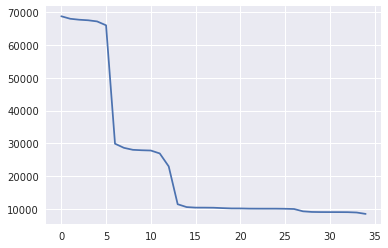

In [26]:
examine_cluster_for_optimal_k(cluster_id)

In [27]:
k = 13

In [27]:
tmp_data = add_week_cycle_features(region_data, k)
print tmp_data.head(2)

            pickup_datetime  count       s_1       c_1       s_2       c_2  \
2680572 2016-01-01 00:00:00     39  0.037391  0.999301  0.074730  0.997204   
2680674 2016-01-01 01:00:00     91  0.074730  0.997204  0.149042  0.988831   

              s_3       c_3       s_4       c_4    ...          s_9       c_9  \
2680572  0.111964  0.993712  0.149042  0.988831    ...     0.330279  0.943883   
2680674  0.222521  0.974928  0.294755  0.955573    ...     0.623490  0.781831   

             s_10      c_10      s_11      c_11      s_12      c_12      s_13  \
2680572  0.365341  0.930874  0.399892  0.916562  0.433884  0.900969  0.467269   
2680674  0.680173  0.733052  0.733052  0.680173  0.781831  0.623490  0.826239   

             c_13  
2680572  0.884115  
2680674  0.563320  

[2 rows x 28 columns]


Добавили необходимое количество признаков в данные и теперь обучим линейную регрессию. Так же получим остатки из линейной регресии. 

In [31]:
model = train_lr(tmp_data)
r = get_residues(tmp_data, model)
print r.head()

                      residual
pickup_datetime               
2016-01-01 00:00:00  17.882213
2016-01-01 01:00:00  70.046567
2016-01-01 02:00:00  54.194056
2016-01-01 03:00:00  34.984066
2016-01-01 04:00:00   0.212411


Нарисуем график остатков

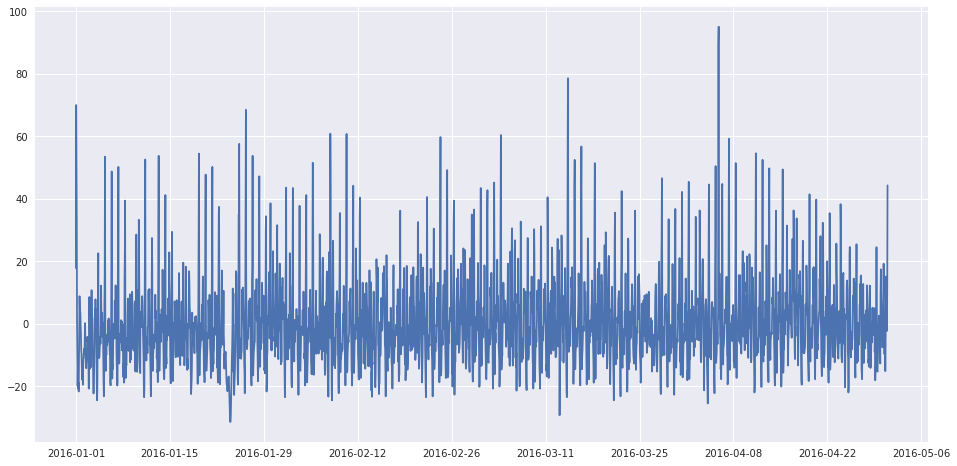

In [32]:
plt.figure(1, figsize=(16,8))
plt.plot(r)
plt.show()

На глаз непонятно является ли данные ряд стационарным. Проведем STL декомпозицию ряда остатков. Как видно на графике ниже тренд нельзя назвать стационарным за счет резких нетипичных для ряда скачков.

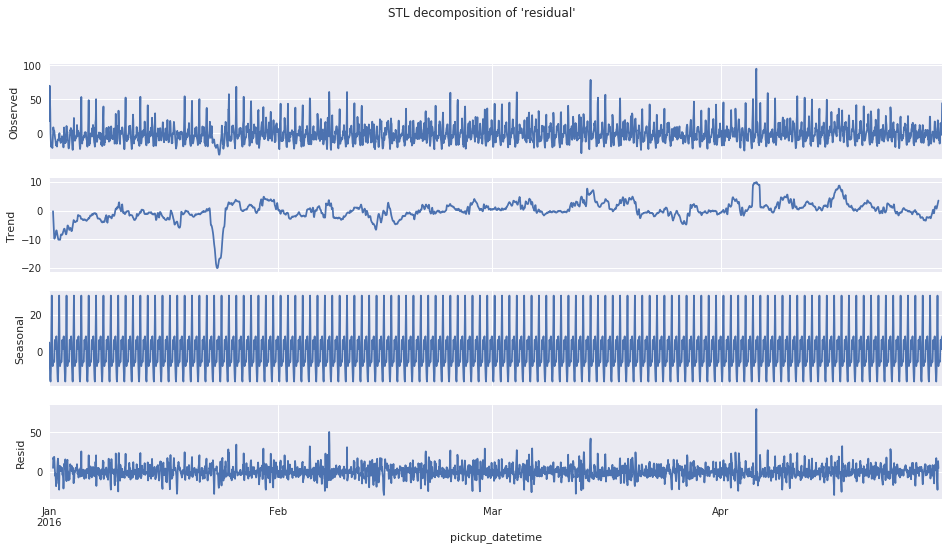

In [33]:
plot_STL_decomposition(r['residual'])

Поэтому попробуем избавиться от этих скачков дифференцированием. Сначала уберем 24 часовую зависимость, а потом произведем единичные дифферецирования.

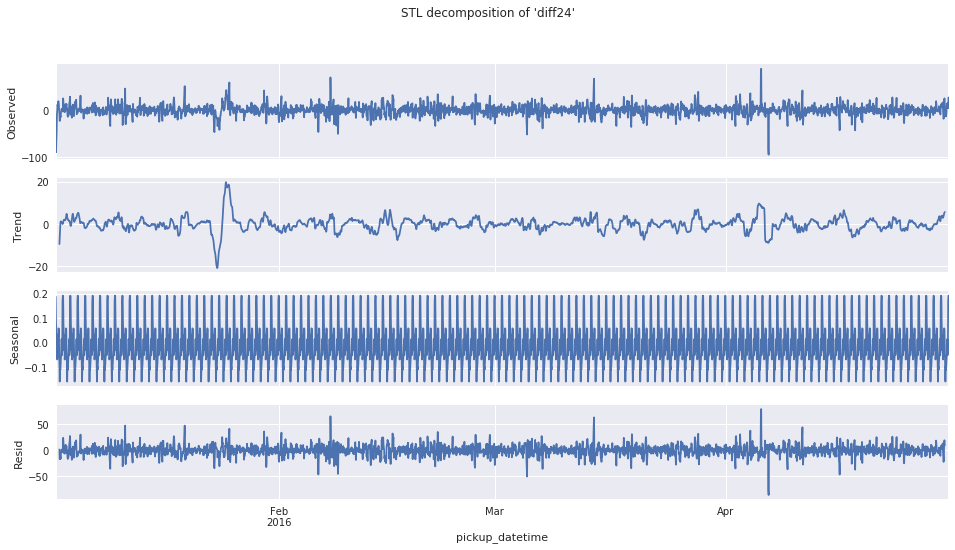

In [34]:
r['diff24'] = r['residual'] - r['residual'].shift(24)
plot_STL_decomposition(r['diff24'][24:])

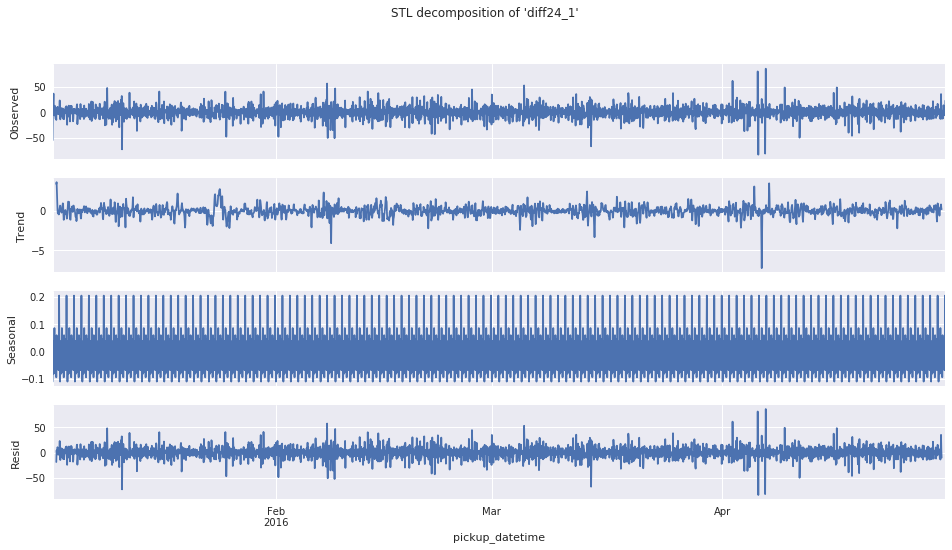

In [35]:
r['diff24_1'] = r['diff24'] - r['diff24'].shift(1)
plot_STL_decomposition(r['diff24_1'][25:])

Теперь построим ACF и PACF графики для определения начальных приближений модели SARIMA.

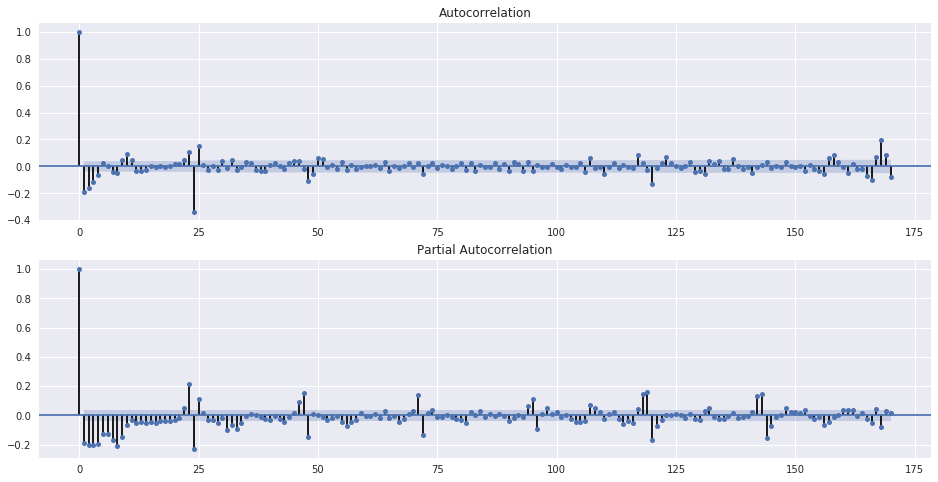

In [36]:
plt.figure(figsize=(16,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(r['diff24_1'][25:], lags=170, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(r['diff24_1'][25:], lags=170, ax=ax)
plt.show()

Пожертвуем точностью ради производительности. Ибо если оставить те начальные приближения параметров, какие должны быть подбор затянется надолго (порядка десятков часов на каждый кластер)

In [40]:
Q = 2
#q = 4
q = 2
P = 2
p = 2
#p = 10
d = 1
D = 1
Qs = range(0, Q + 1)
qs = range(0, q + 1)
Ps = range(0, P + 1)
ps = range(0, p + 1)
from itertools import product
parameters = list(product(ps, [d], qs, Ps, [D], Qs))
print len(parameters)

81


In [38]:
%%time
#data = r['residual'].values
tmp_data = r['residual']
best_model, best_params = train_SARIMAX(tmp_data, parameters, 24)

1  of  81
('wrong parameters:', (0, 1, 0, 0, 1, 0))
2  of  81
3  of  81
4  of  81
5  of  81
6  of  81
7  of  81
8  of  81
9  of  81
10  of  81
11  of  81
12  of  81
13  of  81
14  of  81
15  of  81
16  of  81
17  of  81
18  of  81


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


19  of  81
20  of  81
21  of  81
22  of  81
23  of  81
24  of  81
25  of  81
26  of  81
27  of  81
28  of  81
29  of  81
30  of  81
31  of  81
32  of  81
33  of  81
34  of  81
35  of  81
36  of  81
37  of  81
38  of  81
39  of  81
40  of  81
41  of  81
42  of  81
43  of  81
44  of  81
45  of  81
46  of  81
47  of  81
48  of  81
49  of  81
50  of  81
51  of  81
52  of  81
53  of  81
54  of  81
55  of  81
56  of  81
57  of  81
58  of  81
59  of  81
60  of  81
61  of  81
62  of  81
63  of  81
64  of  81
65  of  81
66  of  81
67  of  81
68  of  81
69  of  81
70  of  81
71  of  81
72  of  81
73  of  81
74  of  81
75  of  81
76  of  81
77  of  81
78  of  81


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


79  of  81


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


80  of  81
81  of  81


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 1h 31min 49s, sys: 1min 6s, total: 1h 32min 55s
Wall time: 23min 20s


In [41]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2904
Model:             SARIMAX(2, 1, 2)x(0, 1, 2, 24)   Log Likelihood               -9810.069
Date:                            Sat, 03 Jun 2017   AIC                          19634.138
Time:                                    07:28:32   BIC                          19675.955
Sample:                                         0   HQIC                         19649.204
                                           - 2904                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0170      0.064     15.829      0.000       0.891       1.143
ar.L2         -0.4019      0.028    -14.367      0.000      -0.457      -0.347
ma.L1         -1.4955      0.082    -18.212      0.000      -1.656      -1.335
ma.L2          0.4954      0.072      6.884      0.000       0.354       0.636
ma.S.L24      -0.7993      2.990     -0.267      0.789      -6.659       5.060
ma.S.L48      -0.2007      0.604     -0.332      0.740      -1.385       0.984
sigma2        64.2289    191.801      0.335      0.738    -311.693     440.151
===================================================================================
Ljung-Box (Q):                      177.29   Jarque-Bera (JB):              6239.82
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                             1.02
Prob(H) (two-sided):                  0.99   Kurtosis:                         9.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Сохраним оптимальные значения параметров

In [28]:
clusters_model[cluster_id] = {'params' : best_params, 's' : 24, 'k' : k}
#clusters_model[cluster_id] = {'params' : (2, 1, 2, 0, 1, 2), 's' : 24, 'k' : k}
print clusters_model

{0: {'s': 24, 'params': (2, 1, 2, 0, 1, 2), 'k': 13}}


In [29]:
write_model_to_file(clusters_model)

Описать настройку каждого кластера откровенно лень. В целом там ничего нового. Копипаста с небольшими изменениями.

## Второй кластер

In [30]:
cluster_id = 1
region_data = cluster_element[cluster_id]
T = region_data.shape[0]
print T

2904


Cluster:  1
Region id:  1173


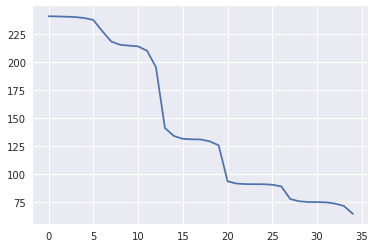

In [31]:
examine_cluster_for_optimal_k(cluster_id)

In [32]:
k = 7

In [32]:
tmp_data = add_week_cycle_features(region_data, k)
print tmp_data.head(2)

            pickup_datetime  count       s_1       c_1       s_2       c_2  \
2680572 2016-01-01 00:00:00     39  0.037391  0.999301  0.074730  0.997204   
2680674 2016-01-01 01:00:00     91  0.074730  0.997204  0.149042  0.988831   

              s_3       c_3       s_4       c_4       s_5       c_5       s_6  \
2680572  0.111964  0.993712  0.149042  0.988831  0.185912  0.982566  0.222521   
2680674  0.222521  0.974928  0.294755  0.955573  0.365341  0.930874  0.433884   

              c_6       s_7       c_7  
2680572  0.974928  0.258819  0.965926  
2680674  0.900969  0.500000  0.866025  


In [48]:
model = train_lr(tmp_data)
r = get_residues(tmp_data, model)
print r.head()

                      residual
pickup_datetime               
2016-01-01 00:00:00   0.840977
2016-01-01 01:00:00   6.792967
2016-01-01 02:00:00 -15.729831
2016-01-01 03:00:00 -22.961590
2016-01-01 04:00:00 -32.886100


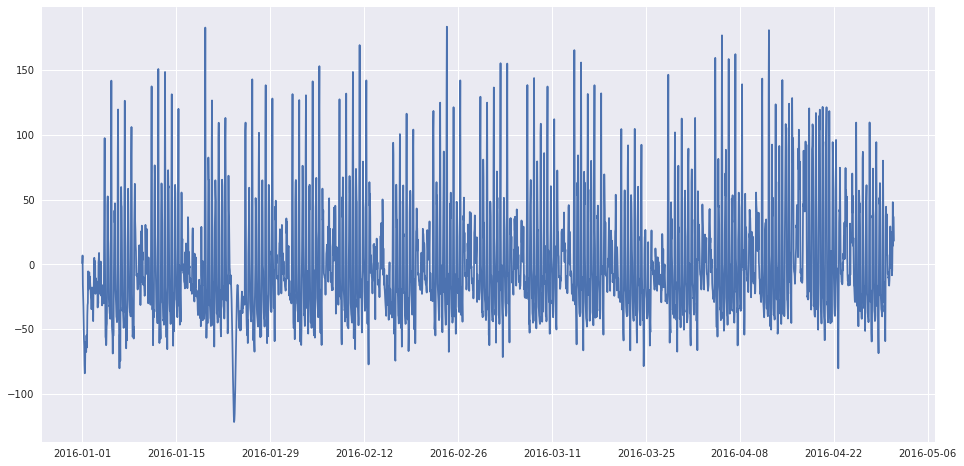

In [49]:
plt.figure(1, figsize=(16,8))
plt.plot(r[r.index >= '2016-01-01'])
plt.show()

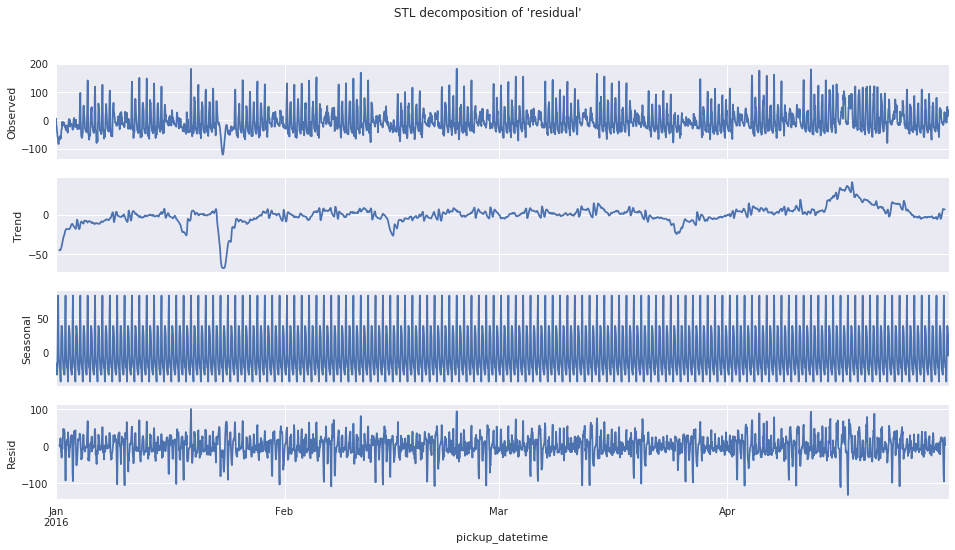

In [50]:
plot_STL_decomposition(r['residual'])

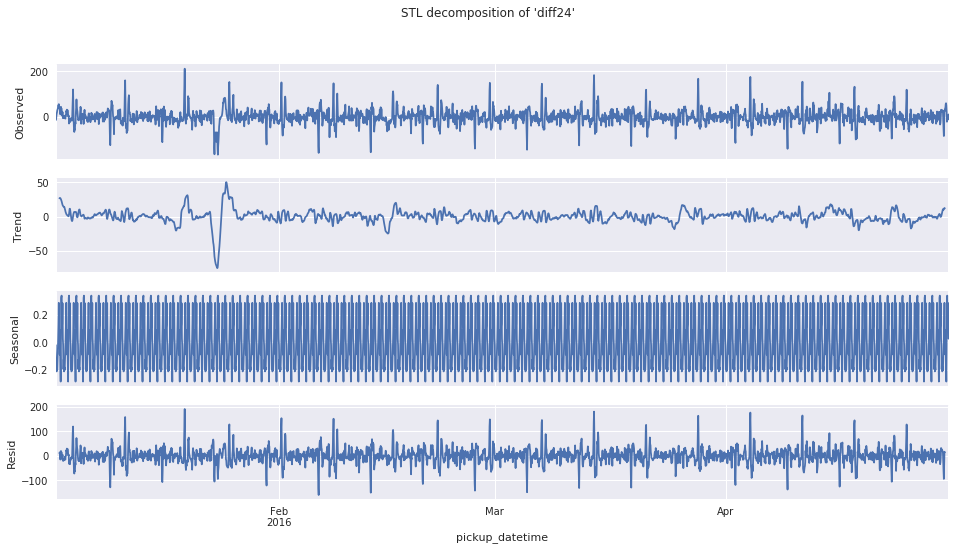

In [51]:
r['diff24'] = r['residual'] - r['residual'].shift(24)
plot_STL_decomposition(r['diff24'][24:])

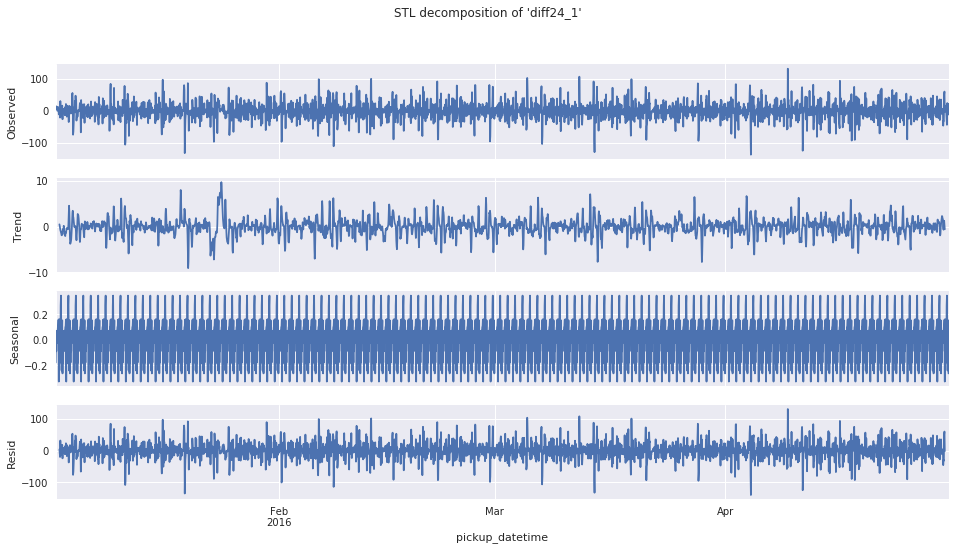

In [52]:
r['diff24_1'] = r['diff24'] - r['diff24'].shift(1)
plot_STL_decomposition(r['diff24_1'][25:])

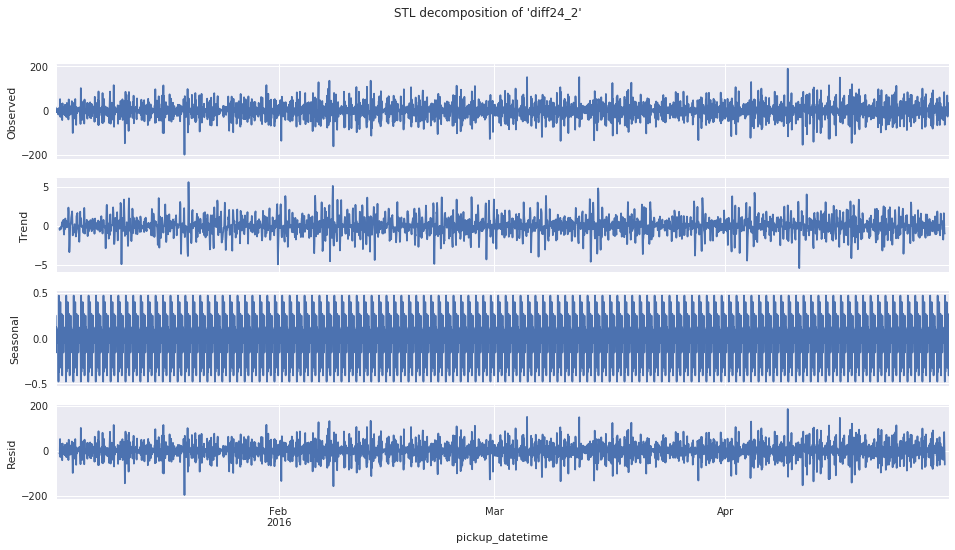

In [53]:
r['diff24_2'] = r['diff24_1'] - r['diff24_1'].shift(1)
plot_STL_decomposition(r['diff24_2'][26:])

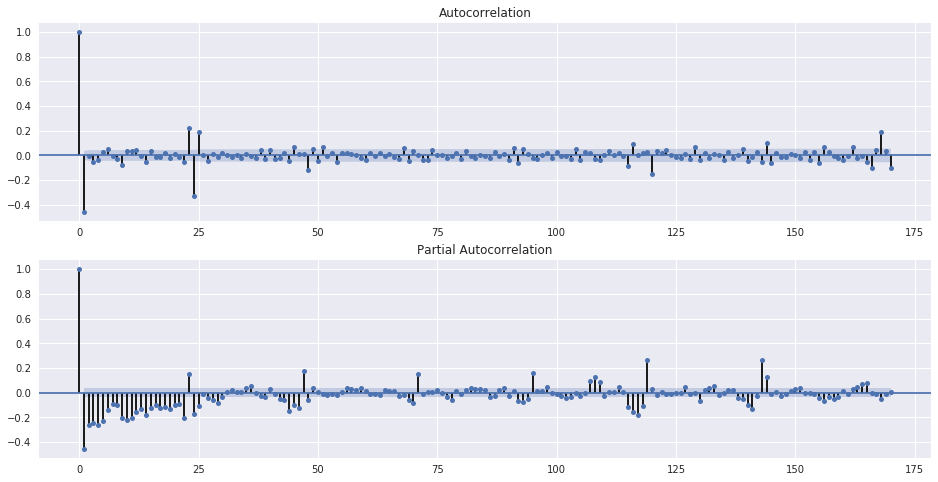

In [54]:
plt.figure(figsize=(16,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(r['diff24_2'][26:], lags=170, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(r['diff24_2'][26:], lags=170, ax=ax)
plt.show()

In [55]:
Q = 1
q = 1
P = 1
p = 10
#p = 18
d = 2
D = 1
Qs = range(0, Q + 1)
qs = range(0, q + 1)
Ps = range(0, P + 1)
ps = range(0, p + 1)
from itertools import product
parameters = list(product(ps, [d], qs, Ps, [D], Qs))
print len(parameters)

88


In [56]:
%%time
tmp_data = r['residual']
best_model, best_params = train_SARIMAX(tmp_data, parameters, 24)

1  of  88
('wrong parameters:', (0, 2, 0, 0, 1, 0))
2  of  88
3  of  88
4  of  88
5  of  88
6  of  88
7  of  88
8  of  88
9  of  88
10  of  88
11  of  88
12  of  88
13  of  88
14  of  88
15  of  88
16  of  88
17  of  88
18  of  88
19  of  88
20  of  88
21  of  88
22  of  88
23  of  88
24  of  88
25  of  88
26  of  88
27  of  88
28  of  88
29  of  88
30  of  88
31  of  88
32  of  88
33  of  88
34  of  88
35  of  88
36  of  88
37  of  88
38  of  88
39  of  88
40  of  88
41  of  88
42  of  88
43  of  88
44  of  88
45  of  88
46  of  88
47  of  88
48  of  88
49  of  88
50  of  88
51  of  88
52  of  88
53  of  88
54  of  88
55  of  88
56  of  88
57  of  88
58  of  88
59  of  88
60  of  88
61  of  88
62  of  88
63  of  88
64  of  88
65  of  88
66  of  88
67  of  88
68  of  88
69  of  88
70  of  88
71  of  88
72  of  88
73  of  88
74  of  88
75  of  88
76  of  88
77  of  88
78  of  88
79  of  88
80  of  88
81  of  88
82  of  88
83  of  88
84  of  88
85  of  88
86  of  88
87  of  88
88  of  88

In [57]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                  Statespace Model Results                                 
===========================================================================================
Dep. Variable:                                   y   No. Observations:                 2904
Model:             SARIMAX(10, 2, 1)x(1, 1, 1, 24)   Log Likelihood              -12518.502
Date:                             Sat, 03 Jun 2017   AIC                          25065.004
Time:                                     07:49:53   BIC                          25148.638
Sample:                                          0   HQIC                         25095.137
                                            - 2904                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2302      0.017    -13.219      0.000      -0.264      -0.196
ar.L2         -0.2201      0.020    -10.888      0.000      -0.260      -0.181
ar.L3         -0.2702      0.021    -12.573      0.000      -0.312      -0.228
ar.L4         -0.3022      0.024    -12.494      0.000      -0.350      -0.255
ar.L5         -0.2571      0.027     -9.653      0.000      -0.309      -0.205
ar.L6         -0.2025      0.027     -7.549      0.000      -0.255      -0.150
ar.L7         -0.2074      0.024     -8.565      0.000      -0.255      -0.160
ar.L8         -0.3066      0.022    -13.937      0.000      -0.350      -0.264
ar.L9         -0.2782      0.021    -13.038      0.000      -0.320      -0.236
ar.L10        -0.1174      0.021     -5.586      0.000      -0.159      -0.076
ma.L1         -1.0000      4.111     -0.243      0.808      -9.058       7.058
ar.S.L24       0.2952      0.018     16.257      0.000       0.260       0.331
ma.S.L24      -1.0151      0.010   -102.043      0.000      -1.035      -0.996
sigma2       423.7737   1743.335      0.243      0.808   -2993.101    3840.648
===================================================================================
Ljung-Box (Q):                      224.32   Jarque-Bera (JB):               154.91
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.08
Prob(H) (two-sided):                  0.17   Kurtosis:                         4.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
#clusters_model[cluster_id] = {'params' : best_params, 's' : 24, 'k' : k}
clusters_model[cluster_id] = {'params' : (10, 2, 1, 1, 1, 1), 's' : 24, 'k' : k}
write_model_to_file(clusters_model)

## Третий кластер

In [34]:
cluster_id = 2
region_data = cluster_element[cluster_id]
T = region_data.shape[0]

Cluster:  2
Region id:  1129


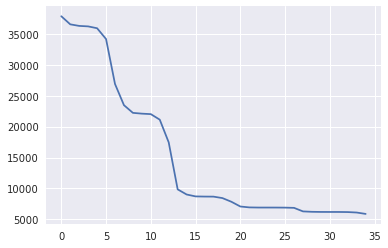

In [35]:
examine_cluster_for_optimal_k(cluster_id)

In [36]:
k = 14

In [37]:
tmp_data = add_week_cycle_features(region_data, k)
print tmp_data.head(2)

            pickup_datetime  count       s_1       c_1       s_2       c_2  \
2680568 2016-01-01 00:00:00    846  0.037391  0.999301  0.074730  0.997204   
2680670 2016-01-01 01:00:00    594  0.074730  0.997204  0.149042  0.988831   

              s_3       c_3       s_4       c_4    ...         s_10      c_10  \
2680568  0.111964  0.993712  0.149042  0.988831    ...     0.365341  0.930874   
2680670  0.222521  0.974928  0.294755  0.955573    ...     0.680173  0.733052   

             s_11      c_11      s_12      c_12      s_13      c_13      s_14  \
2680568  0.399892  0.916562  0.433884  0.900969  0.467269  0.884115  0.500000   
2680670  0.733052  0.680173  0.781831  0.623490  0.826239  0.563320  0.866025   

             c_14  
2680568  0.866025  
2680670  0.500000  

[2 rows x 30 columns]


In [39]:
model = train_lr(tmp_data)
r = get_residues(tmp_data, model)
print r.head()

                       residual
pickup_datetime                
2016-01-01 00:00:00  159.528842
2016-01-01 01:00:00    7.777881
2016-01-01 02:00:00  -84.690022
2016-01-01 03:00:00   -7.794005
2016-01-01 04:00:00   90.297012


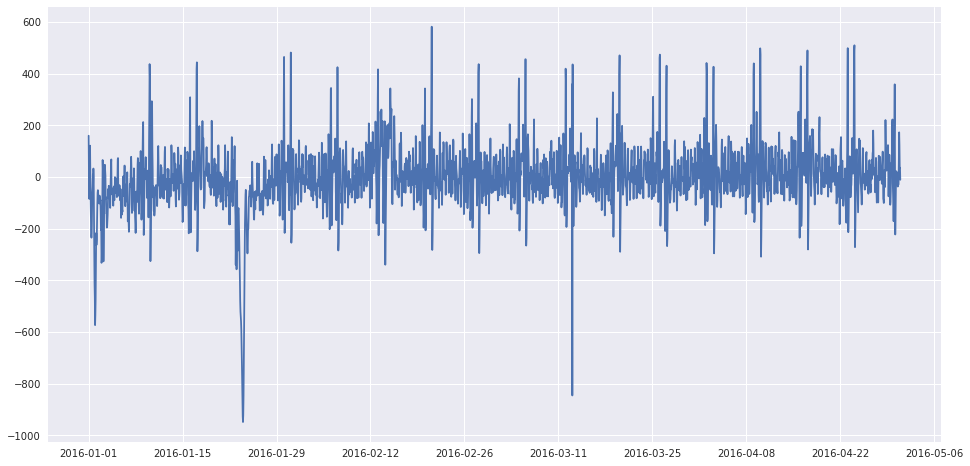

In [40]:
plt.figure(1, figsize=(16,8))
plt.plot(r[r.index >= '2016-01-01'])
plt.show()

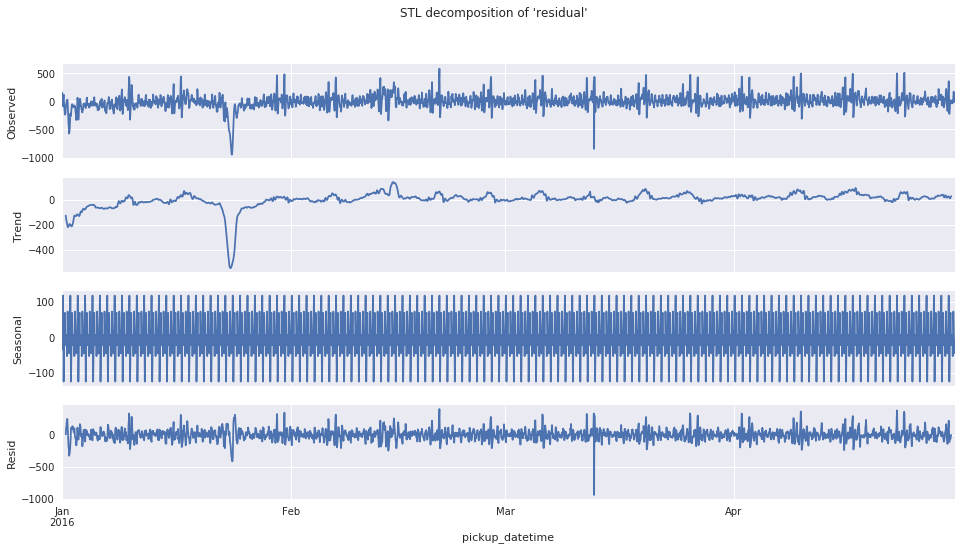

In [65]:
plot_STL_decomposition(r['residual'])

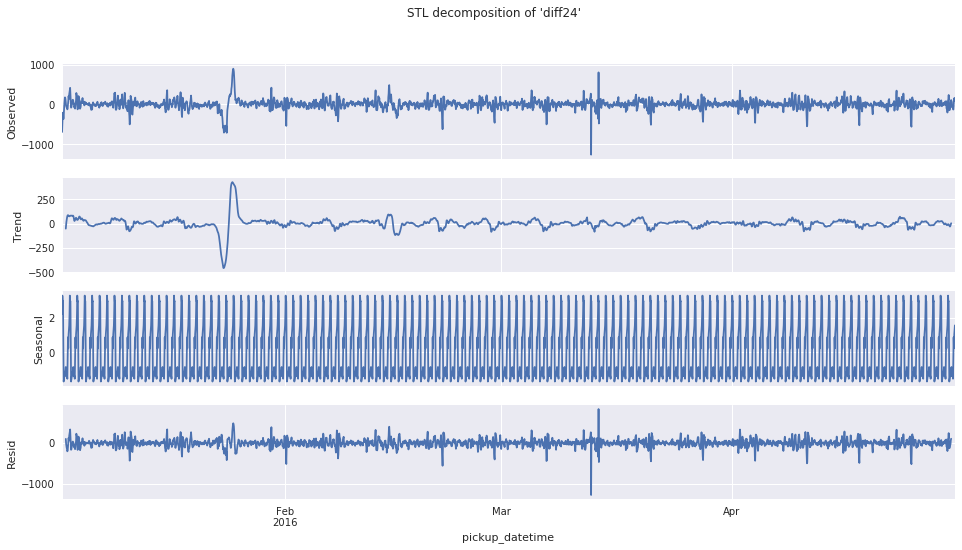

In [66]:
r['diff24'] = r['residual'] - r['residual'].shift(24)
plot_STL_decomposition(r['diff24'][24:])

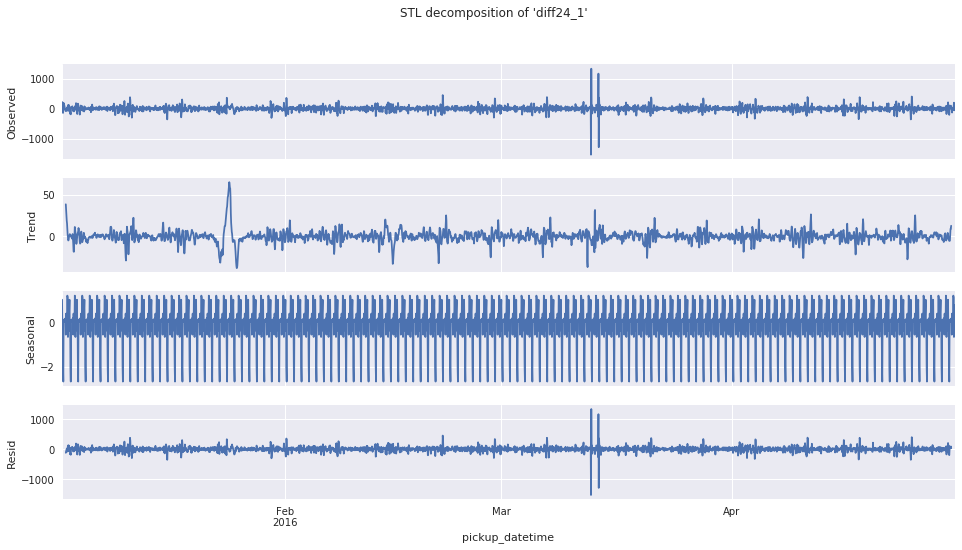

In [67]:
r['diff24_1'] = r['diff24'] - r['diff24'].shift(1)
plot_STL_decomposition(r['diff24_1'][25:])

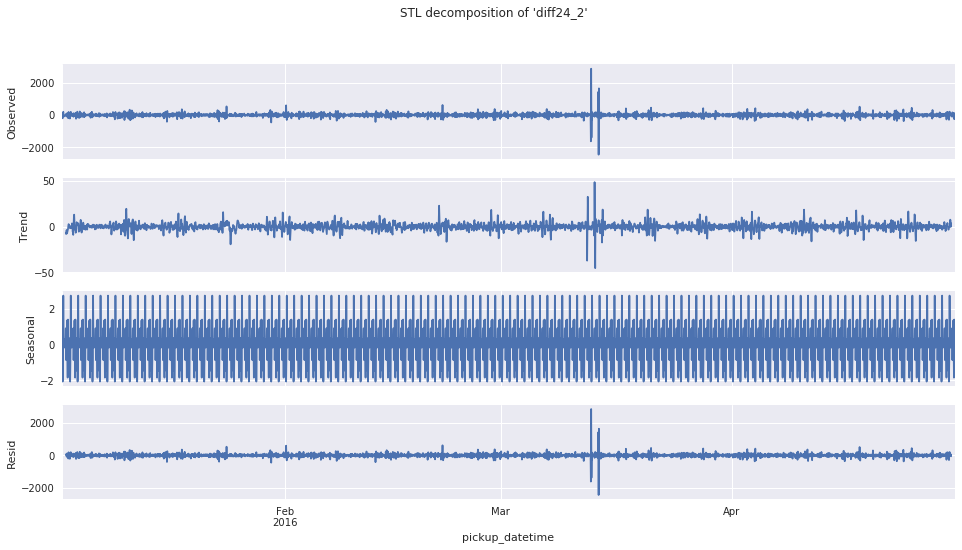

In [68]:
r['diff24_2'] = r['diff24_1'] - r['diff24_1'].shift(1)
plot_STL_decomposition(r['diff24_2'][26:])

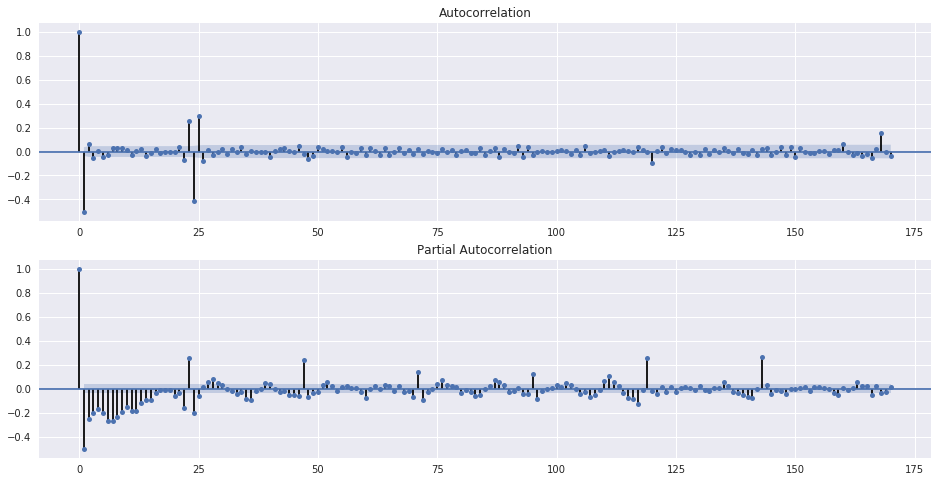

In [69]:
plt.figure(figsize=(16,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(r['diff24_2'][26:], lags=170, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(r['diff24_2'][26:], lags=170, ax=ax)
plt.show()

In [70]:
Q = 1
q = 2
P = 2
#p = 15
p = 6
d = 2
D = 1
Qs = range(0, Q + 1)
qs = range(0, q + 1)
Ps = range(0, P + 1)
ps = range(0, p + 1)
from itertools import product
parameters = list(product(ps, [d], qs, Ps, [D], Qs))
print len(parameters)

126


In [71]:
%%time
tmp_data = r['residual']
best_model, best_params = train_SARIMAX(tmp_data, parameters, 24)

1  of  126
('wrong parameters:', (0, 2, 0, 0, 1, 0))
2  of  126
3  of  126
4  of  126
5  of  126
6  of  126
7  of  126
8  of  126
9  of  126
10  of  126
11  of  126
12  of  126
13  of  126
14  of  126
15  of  126
16  of  126
17  of  126
18  of  126
19  of  126
20  of  126
21  of  126
22  of  126
23  of  126
24  of  126
25  of  126
26  of  126
27  of  126
28  of  126
29  of  126
30  of  126
31  of  126
32  of  126
33  of  126
34  of  126
35  of  126
36  of  126
37  of  126
38  of  126
39  of  126
40  of  126
41  of  126
42  of  126
43  of  126
44  of  126
45  of  126
46  of  126
47  of  126
48  of  126
49  of  126
50  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


51  of  126
52  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


53  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


54  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


55  of  126
56  of  126
57  of  126
58  of  126
59  of  126
60  of  126
61  of  126
62  of  126
63  of  126
64  of  126
65  of  126
66  of  126
67  of  126
68  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


69  of  126
70  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


71  of  126
72  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


73  of  126
74  of  126
75  of  126
76  of  126
77  of  126
78  of  126
79  of  126
80  of  126
81  of  126
82  of  126
83  of  126
84  of  126
85  of  126
86  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


87  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


88  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


89  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


90  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


91  of  126
92  of  126
93  of  126
94  of  126
95  of  126
96  of  126
97  of  126
98  of  126
99  of  126
100  of  126
101  of  126
102  of  126
103  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


104  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


105  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


106  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


107  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


108  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


109  of  126
110  of  126
111  of  126
112  of  126
113  of  126
114  of  126
115  of  126
116  of  126
117  of  126
118  of  126
119  of  126
120  of  126
121  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


122  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


123  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


124  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


125  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


126  of  126


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 3h 19min 5s, sys: 2min 1s, total: 3h 21min 7s
Wall time: 51min 13s


In [67]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  720
Model:             SARIMAX(6, 2, 1)x(2, 1, 1, 24)   Log Likelihood               -3495.773
Date:                            Tue, 23 May 2017   AIC                           7013.545
Time:                                    20:14:43   BIC                           7063.917
Sample:                                         0   HQIC                          7032.991
                                            - 720                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0541      0.034      1.588      0.112      -0.013       0.121
ar.L2         -0.2337      0.032     -7.344      0.000      -0.296      -0.171
ar.L3         -0.1604      0.031     -5.222      0.000      -0.221      -0.100
ar.L4         -0.2938      0.036     -8.119      0.000      -0.365      -0.223
ar.L5         -0.2075      0.038     -5.411      0.000      -0.283      -0.132
ar.L6         -0.2165      0.039     -5.599      0.000      -0.292      -0.141
ma.L1         -1.0000     99.104     -0.010      0.992    -195.241     193.241
ar.S.L24       0.2582      0.034      7.701      0.000       0.193       0.324
ar.S.L48      -0.2010      0.037     -5.415      0.000      -0.274      -0.128
ma.S.L24      -1.0084      0.219     -4.597      0.000      -1.438      -0.578
sigma2      2844.9581   2.82e+05      0.010      0.992    -5.5e+05    5.56e+05
===================================================================================
Ljung-Box (Q):                      115.13   Jarque-Bera (JB):               134.21
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.18
Prob(H) (two-sided):                  0.05   Kurtosis:                         5.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
#clusters_model[cluster_id] = {'params' : best_params, 's' : 24, 'k' : k}
clusters_model[cluster_id] = {'params' : (6, 2, 1, 2, 1, 1), 's' : 24, 'k' : k}
write_model_to_file(clusters_model)

## Четвертый кластер

In [38]:
cluster_id = 3
region_data = cluster_element[cluster_id]
T = region_data.shape[0]

Cluster:  3
Region id:  1076


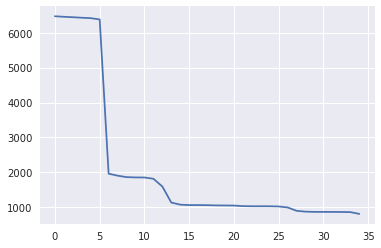

In [39]:
examine_cluster_for_optimal_k(cluster_id)

In [40]:
k = 14

In [45]:
tmp_data = add_week_cycle_features(region_data, k)
print tmp_data.head(2)

            pickup_datetime  count       s_1       c_1       s_2       c_2  \
2680563 2016-01-01 00:00:00     77  0.037391  0.999301  0.074730  0.997204   
2680665 2016-01-01 01:00:00    134  0.074730  0.997204  0.149042  0.988831   

              s_3       c_3       s_4       c_4    ...         s_10      c_10  \
2680563  0.111964  0.993712  0.149042  0.988831    ...     0.365341  0.930874   
2680665  0.222521  0.974928  0.294755  0.955573    ...     0.680173  0.733052   

             s_11      c_11      s_12      c_12      s_13      c_13      s_14  \
2680563  0.399892  0.916562  0.433884  0.900969  0.467269  0.884115  0.500000   
2680665  0.733052  0.680173  0.781831  0.623490  0.826239  0.563320  0.866025   

             c_14  
2680563  0.866025  
2680665  0.500000  

[2 rows x 30 columns]


In [46]:
model = train_lr(tmp_data)
r = get_residues(tmp_data, model)
print r.head()

                      residual
pickup_datetime               
2016-01-01 00:00:00   0.542640
2016-01-01 01:00:00  83.442457
2016-01-01 02:00:00  80.127009
2016-01-01 03:00:00  44.217566
2016-01-01 04:00:00  37.240391


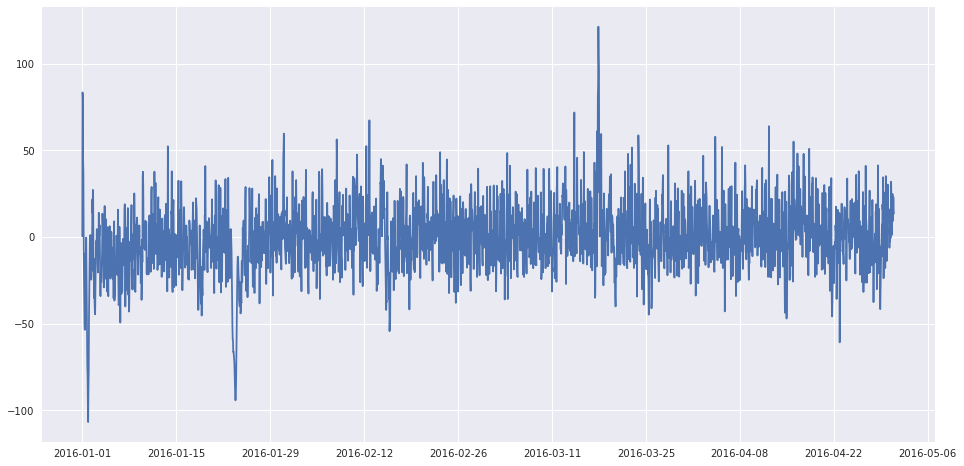

In [47]:
plt.figure(1, figsize=(16,8))
plt.plot(r[r.index >= '2016-01-01'])
plt.show()

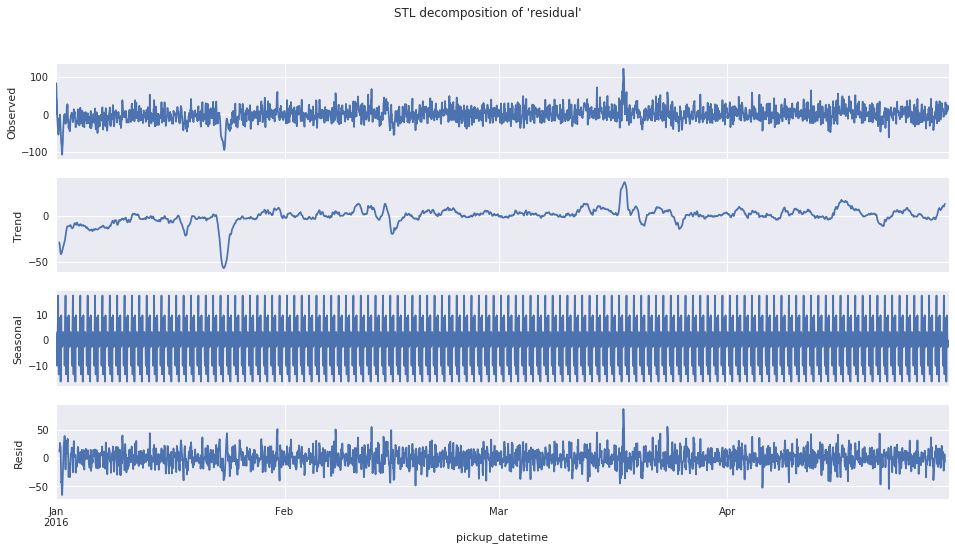

In [48]:
plot_STL_decomposition(r['residual'])

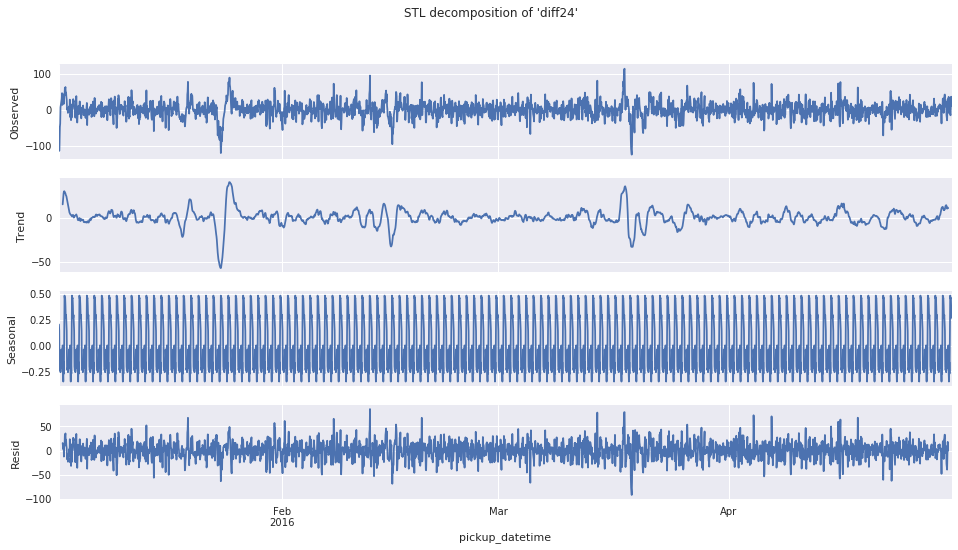

In [49]:
r['diff24'] = r['residual'] - r['residual'].shift(24)
plot_STL_decomposition(r['diff24'][24:])

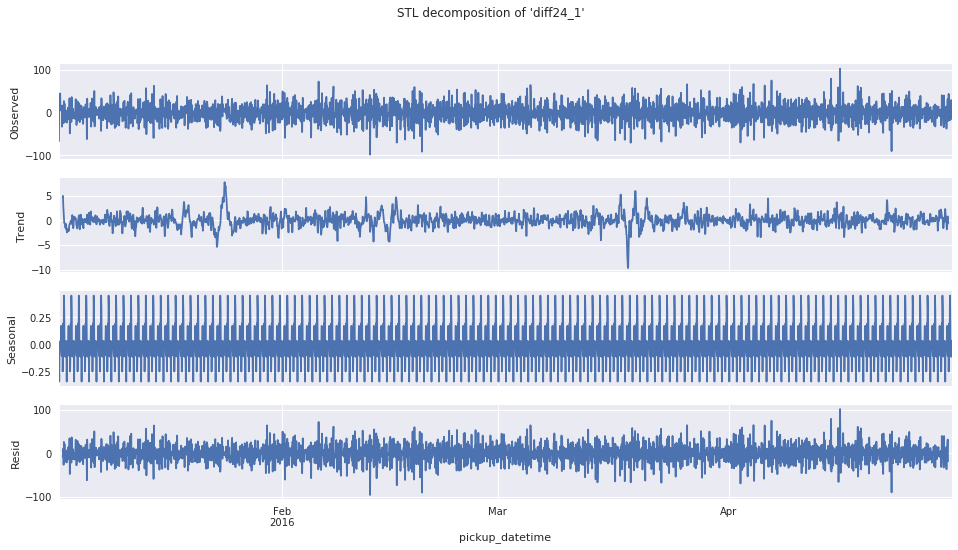

In [50]:
r['diff24_1'] = r['diff24'] - r['diff24'].shift(1)
plot_STL_decomposition(r['diff24_1'][25:])

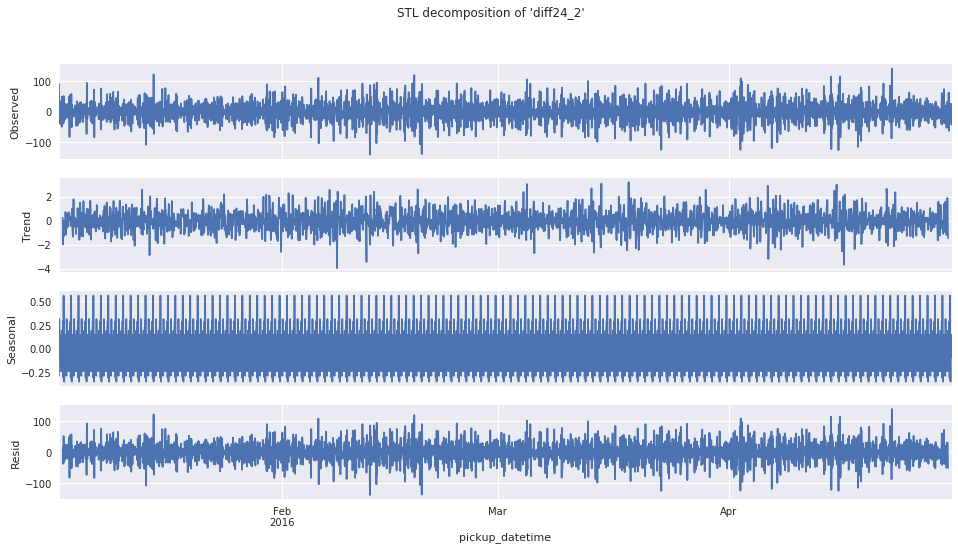

In [51]:
r['diff24_2'] = r['diff24_1'] - r['diff24_1'].shift(1)
plot_STL_decomposition(r['diff24_2'][26:])

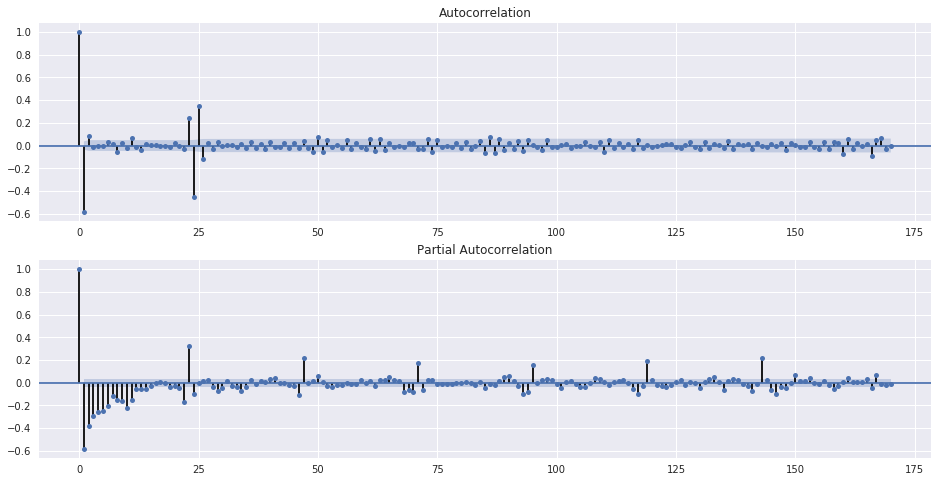

In [52]:
plt.figure(figsize=(16,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(r['diff24_2'][26:], lags=170, ax=ax)
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(r['diff24_2'][26:], lags=170, ax=ax)
plt.show()

In [54]:
Q = 1
q = 2
P = 1
#p = 14
p = 8
d = 2
D = 1
Qs = range(0, Q + 1)
qs = range(0, q + 1)
Ps = range(0, P + 1)
ps = range(0, p + 1)
from itertools import product
parameters = list(product(ps, [d], qs, Ps, [D], Qs))
print len(parameters)

108


In [55]:
%%time
data = r['residual']
best_model, best_params = train_SARIMAX(data, parameters, 24)

1  of  108
('wrong parameters:', (0, 2, 0, 0, 1, 0))
2  of  108
3  of  108
4  of  108
5  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


6  of  108
7  of  108
8  of  108
9  of  108
10  of  108
11  of  108
12  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


13  of  108
14  of  108
15  of  108
16  of  108
17  of  108
18  of  108
19  of  108
20  of  108
21  of  108
22  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


23  of  108
24  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


25  of  108
26  of  108
27  of  108
28  of  108
29  of  108
30  of  108
31  of  108
32  of  108
33  of  108
34  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


35  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


36  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


37  of  108
38  of  108
39  of  108
40  of  108
41  of  108
42  of  108
43  of  108
44  of  108
45  of  108
46  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


47  of  108
48  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


49  of  108
50  of  108
51  of  108
52  of  108
53  of  108
54  of  108
55  of  108
56  of  108
57  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


58  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


59  of  108
60  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


61  of  108
62  of  108
63  of  108
64  of  108
65  of  108
66  of  108
67  of  108
68  of  108
69  of  108
70  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


71  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


72  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


73  of  108
74  of  108
75  of  108
76  of  108
77  of  108
78  of  108
79  of  108
80  of  108
81  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


82  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


83  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


84  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


85  of  108
86  of  108
87  of  108
88  of  108
89  of  108
90  of  108
91  of  108
92  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


93  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


94  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


95  of  108
96  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


97  of  108
98  of  108
99  of  108
100  of  108
101  of  108
102  of  108
103  of  108
104  of  108
105  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


106  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


107  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


108  of  108


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 2h 2min 23s, sys: 1min 14s, total: 2h 3min 38s
Wall time: 32min 7s


In [56]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2904
Model:             SARIMAX(1, 2, 2)x(0, 1, 1, 24)   Log Likelihood              -11646.307
Date:                            Sat, 03 Jun 2017   AIC                          23302.614
Time:                                    12:36:02   BIC                          23332.483
Sample:                                         0   HQIC                         23313.375
                                           - 2904                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3690      0.014     26.041      0.000       0.341       0.397
ma.L1         -1.9601      0.035    -55.669      0.000      -2.029      -1.891
ma.L2          0.9601      0.034     28.458      0.000       0.894       1.026
ma.S.L24      -1.0730      0.008   -132.032      0.000      -1.089      -1.057
sigma2       164.9417      7.362     22.405      0.000     150.513     179.370
===================================================================================
Ljung-Box (Q):                      389.98   Jarque-Bera (JB):               175.09
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.13
Prob(H) (two-sided):                  0.52   Kurtosis:                         4.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [41]:
#clusters_model[cluster_id] = {'params' : best_params, 's' : 24, 'k' : k}
clusters_model[cluster_id] = {'params' : (1, 2, 2, 0, 1, 1), 's' : 24, 'k' : k}

Наконец, все кластеры обучены. Можно переходить к обучению 102 моделей.

## Обучение моделей для каждого региона

In [42]:
regions

array([1075, 1076, 1077, 1125, 1126, 1127, 1128, 1129, 1130, 1131, 1132,
       1172, 1173, 1174, 1175, 1176, 1177, 1178, 1179, 1180, 1181, 1182,
       1183, 1184, 1221, 1222, 1223, 1224, 1225, 1227, 1228, 1229, 1230,
       1231, 1232, 1233, 1234, 1235, 1272, 1273, 1274, 1278, 1279, 1280,
       1281, 1282, 1283, 1284, 1285, 1286, 1287, 1326, 1327, 1331, 1332,
       1333, 1334, 1335, 1336, 1337, 1338, 1339, 1376, 1377, 1378, 1380,
       1382, 1383, 1384, 1385, 1386, 1387, 1388, 1389, 1390, 1426, 1431,
       1434, 1435, 1436, 1437, 1438, 1439, 1441, 1442, 1480, 1482, 1483,
       1530, 1532, 1533, 1580, 1630, 1684, 1733, 1734, 1783, 2068, 2069,
       2118, 2119, 2168])

In [44]:
clusters_model

{0: {'k': 13, 'params': (2, 1, 2, 0, 1, 2), 's': 24},
 1: {'k': 7, 'params': (10, 2, 1, 1, 1, 1), 's': 24},
 2: {'k': 14, 'params': (6, 2, 1, 2, 1, 1), 's': 24},
 3: {'k': 14, 'params': (1, 2, 2, 0, 1, 1), 's': 24}}

В данной части задания необходимо обучить 102 модели на данных до мая и посчитать метрику на мае. Поступим следующий образом: пройдемся по всем регионам, на каждом подготовим данные, обучим модели и подсчитаем метрику для данного региона. Полученную метрику добавим в общую. В итоге получим метрику на всех регионах.

In [45]:
%%time
quality = 0.0
R = float(len(regions))
for region in regions:
    
    begin_april = '2016-04-01 00:00:00'
    begin_may = '2016-05-01 00:00:00'
    end_april = '2016-04-30 23:00:00'
    end_may = '2016-05-31 23:00:00'
    cluster_id = get_region_cluster_id(region)
    model_params = clusters_model[cluster_id]
    param = model_params['params']
    print 'region: ', region
    
    data = get_region_data(all_data, region)
    data = data[(data['pickup_datetime'] >= begin_april) & (data['pickup_datetime'] <= end_may)]
    data = pd.DataFrame(data=data['count'].values, index=data['pickup_datetime'], columns=['count'])
    T = data.shape[0]
    for i in range(1, model_params['k'] + 1):
        data["s_" + str(i)] = np.sin(np.array(range(T)) * 2. * np.pi * float(i) / 168.)
        data["c_" + str(i)] = np.cos(np.array(range(T)) * 2. * np.pi * float(i) / 168.)
    train_data = data[begin_april:end_april]
    X_train = train_data[train_data.columns[1:]]
    y_train = train_data['count']
    X = data[data.columns[1:]]
    y = data['count']
    y_test = data['count'][begin_may:end_may]
    
    lr_model = LinearRegression(n_jobs=-1)
    lr_model.fit(X_train, y_train)
    lr_prediction = pd.DataFrame(data=lr_model.predict(X), index=X.index, columns=['prediction'])['prediction']
    r = pd.DataFrame(index=data.index, data=(y - lr_prediction).values, columns=['residual'])
    r_train = r[begin_april:end_april]

    sarimax_model = sm.tsa.statespace.SARIMAX(r_train, order=(param[0], param[1], param[2]),
                                      seasonal_order=(param[3], param[4], param[5], 24),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit(disp=-1)
    sarimax_model = sm.tsa.statespace.SARIMAX(r, order=(param[0], param[1], param[2]),
                                      seasonal_order=(param[3], param[4], param[5], 24),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).filter(sarimax_model.params)
    
    day_id = 0
    may_dates = pd.date_range(begin_may, end_may, freq='1H')
    region_quality = 0.0
    while day_id + 5 < len(may_dates):
        start_date = may_dates[day_id]
        end_date = may_dates[day_id + 5]
        sarimax_prediction = sarimax_model.predict(start=start_date, end=end_date, dynamic=True)
        prediction = lr_prediction[start_date:end_date] + sarimax_prediction
        region_quality += np.abs(y_test[start_date:end_date] - prediction).sum()
        day_id += 1
    print 'region quality: ', region_quality
    quality += region_quality / (R * 739. * 6.)
print quality

region:  1075


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  53212.5646546
region:  1076


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  89662.2283682
region:  1077


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  92779.5707486
region:  1125


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  53221.2495707
region:  1126
region quality:  140833.885997
region:  1127
region quality:  166223.346016
region:  1128


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  198591.097338
region:  1129
region quality:  242185.087185
region:  1130
region quality:  322234.911601
region:  1131


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  171006.150605
region:  1132
region quality:  96442.759311
region:  1172


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  15635.5747371
region:  1173
region quality:  41510.0090459
region:  1174


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  42795.8990135
region:  1175


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  27455.0977896
region:  1176
region quality:  29813.0927119
region:  1177
region quality:  293646.803423
region:  1178
region quality:  316125.074489
region:  1179
region quality:  217936.643777
region:  1180


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  255105.893381
region:  1181
region quality:  475166.080168
region:  1182
region quality:  390067.579369
region:  1183
region quality:  137414.176377
region:  1184


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  28537.1635393
region:  1221


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  13121.6169881
region:  1222
region quality:  21743.8972483
region:  1223


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  31596.0878186
region:  1224


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  34022.4723968
region:  1225
region quality:  13608.944296
region:  1227
region quality:  207541.275303
region:  1228
region quality:  305106.628522
region:  1229


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  286987.083152
region:  1230
region quality:  371517.28286
region:  1231
region quality:  332622.483141
region:  1232


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  388874.670859
region:  1233
region quality:  295166.325284
region:  1234


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  200782.704063
region:  1235
region quality:  99788.9885831
region:  1272
region quality:  16614.9074499
region:  1273
region quality:  34599.3250674
region:  1274
region quality:  15295.1690845
region:  1278
region quality:  21583.5512819
region:  1279
region quality:  35282.6278641
region:  1280
region quality:  120435.398942
region:  1281
region quality:  353040.152199
region:  1282
region quality:  469667.538174
region:  1283


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  167840.847718
region:  1284


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  66113.019232
region:  1285


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  153421.444134
region:  1286
region quality:  184826.940084
region:  1287
region quality:  59396.657361
region:  1326
region quality:  45458.8214841
region:  1327


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  52654.2758926
region:  1331


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  53149.1462101
region:  1332
region quality:  306067.94279
region:  1333
region quality:  435268.226372
region:  1334


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  283474.332819
region:  1335


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  104266.128779
region:  1336


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  55327.8748892
region:  1337


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  63790.2850245
region:  1338
region quality:  66923.1780248
region:  1339


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  16055.3712984
region:  1376
region quality:  35260.8321994
region:  1377
region quality:  21972.1920726
region:  1378


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  15983.6051372
region:  1380
region quality:  15388.9673404
region:  1382
region quality:  30092.4394546
region:  1383
region quality:  240747.6147
region:  1384
region quality:  355695.353577
region:  1385


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  175477.772642
region:  1386
region quality:  38320.9162327
region:  1387
region quality:  37532.2648714
region:  1388
region quality:  27870.7155855
region:  1389


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  20575.6842972
region:  1390
region quality:  23113.1274103
region:  1426


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  16233.9797995
region:  1431


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  24218.2277543
region:  1434
region quality:  18243.7522946
region:  1435
region quality:  13194.1961688
region:  1436


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  30406.1919065
region:  1437


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  39868.089009
region:  1438
region quality:  17435.3023969
region:  1439
region quality:  14395.9855668
region:  1441
region quality:  10987.4243849
region:  1442
region quality:  14121.3141659
region:  1480


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  17161.8029409
region:  1482
region quality:  17608.2367501
region:  1483


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  16925.1294774
region:  1530
region quality:  21127.9772294
region:  1532


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  13905.7243923
region:  1533
region quality:  19474.8519994
region:  1580


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  11524.0910553
region:  1630


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  11077.5737361
region:  1684
region quality:  31994.0744495
region:  1733
region quality:  11008.283219
region:  1734


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  156187.117463
region:  1783


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  195284.519081
region:  2068


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  81591.2887774
region:  2069


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  20122.7291652
region:  2118


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  106731.56199
region:  2119
region quality:  55534.9085834
region:  2168


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region quality:  71643.3027568
26.0391508662
CPU times: user 14h 45min 21s, sys: 28min 55s, total: 15h 14min 16s
Wall time: 3h 48min 32s


Как видно выше, метрика равна 26.0391508662. Что не сильно отличается от результата на кегле.

Теперь обучим на данных до июня и выведем предсказания на 6 часов вперед для июня. Единственное что. Я id немного неверно построил тут, но на кегель отослал с верными id результаты. Разница только в том, что я указывал в качестве конца истории не дату, после которых шло предсказание, а последнюю дату предсказания. Например, первые id у меня были на 2016-06-01_5, а не 2016-05-31_23. Я не пересчитывал с новыми id, т.к. расчет идут 7 часов и это утомляет, а ответы по сути есть. С помощью небольшой программы на python я поправил id на верные.

In [45]:
import os
filename = "results.txt"
if os.path.exists(filename):
    os.remove(filename)
with open(filename, 'a') as f:
    f.write("id,y\n")
def write_to_file(region, date, results):
    id_str = str(region) + "_"
    id_str += str(date.date()) + "_" + str(end_date.hour) + "_"
    with open(filename, 'a') as f:
        for i in range(1, 7):
            f.write(id_str + str(i) + "," + str(results[i - 1]) + '\n')

In [46]:
%%time
for region in regions:
    
    begin_april = '2016-04-01 00:00:00'
    begin_may = '2016-05-01 00:00:00'
    begin_june = '2016-06-01 00:00:00'
    end_april = '2016-04-30 23:00:00'
    end_may = '2016-05-31 23:00:00'
    end_june = '2016-06-30 23:00:00'
    cluster_id = get_region_cluster_id(region)
    model_params = clusters_model[cluster_id]
    param = model_params['params']
    print 'region: ', region
    
    data = get_region_data(all_data, region)
    data = data[(data['pickup_datetime'] >= begin_april) & (data['pickup_datetime'] <= end_june)]
    data = pd.DataFrame(data=data['count'].values, index=data['pickup_datetime'], columns=['count'])
    T = data.shape[0]
    for i in range(1, model_params['k'] + 1):
        data["s_" + str(i)] = np.sin(np.array(range(T)) * 2. * np.pi * float(i) / 168.)
        data["c_" + str(i)] = np.cos(np.array(range(T)) * 2. * np.pi * float(i) / 168.)
    train_data = data[begin_april:end_may]
    X_train = train_data[train_data.columns[1:]]
    y_train = train_data['count']
    X = data[data.columns[1:]]
    y = data['count']
    y_test = data['count'][begin_june:end_june]
    
    lr_model = LinearRegression(n_jobs=-1)
    lr_model.fit(X_train, y_train)
    lr_prediction = pd.DataFrame(data=lr_model.predict(X), index=X.index, columns=['prediction'])['prediction']
    r = pd.DataFrame(index=data.index, data=(y - lr_prediction).values, columns=['residual'])
    r_train = r[begin_april:end_may]

    sarimax_model = sm.tsa.statespace.SARIMAX(r_train, order=(param[0], param[1], param[2]),
                                      seasonal_order=(param[3], param[4], param[5], 24),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).fit(disp=-1)
    sarimax_model = sm.tsa.statespace.SARIMAX(r, order=(param[0], param[1], param[2]),
                                      seasonal_order=(param[3], param[4], param[5], 24),
                                      enforce_stationarity=False,
                                      enforce_invertibility=False).filter(sarimax_model.params)
    
    day_id = 0
    june_dates = pd.date_range(begin_june, end_june, freq='1H')
    while day_id + 5 < len(june_dates):
        start_date = june_dates[day_id]
        end_date = june_dates[day_id + 5]
        sarimax_prediction = sarimax_model.predict(start=start_date, end=end_date, dynamic=True)
        prediction = lr_prediction[start_date:end_date] + sarimax_prediction
        write_to_file(region, end_date, prediction.values)
        day_id += 1

region:  1075
region:  1076
region:  1077
region:  1125
region:  1126
region:  1127
region:  1128
region:  1129
region:  1130
region:  1131
region:  1132
region:  1172
region:  1173
region:  1174


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1175
region:  1176
region:  1177
region:  1178


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1179


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1180


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1181


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1182


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1183
region:  1184


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1221


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1222


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1223
region:  1224


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1225
region:  1227
region:  1228
region:  1229
region:  1230


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1231


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1232
region:  1233


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1234
region:  1235
region:  1272
region:  1273
region:  1274


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1278
region:  1279
region:  1280
region:  1281
region:  1282


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1283


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1284


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1285
region:  1286


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1287


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1326
region:  1327
region:  1331
region:  1332
region:  1333
region:  1334


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1335


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1336


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1337
region:  1338
region:  1339


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1376
region:  1377
region:  1378


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1380


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1382
region:  1383


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1384
region:  1385


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1386


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1387
region:  1388
region:  1389


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1390
region:  1426
region:  1431


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1434


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1435


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1436
region:  1437


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1438
region:  1439
region:  1441


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1442
region:  1480


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1482
region:  1483
region:  1530
region:  1532
region:  1533


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1580
region:  1630


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1684


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1733
region:  1734


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  1783


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  2068


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  2069


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  2118


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


region:  2119
region:  2168


/home/ubuntu/anaconda2/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 1d 3h 22min 17s, sys: 1h 22min 55s, total: 1d 4h 45min 13s
Wall time: 7h 11min 15s


Ссылка на результат в кегле: https://inclass.kaggle.com/submissions/4891589/4891589.zip